In [1]:
!pip install transformers
!pip install sentence-transformers

In [19]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import transformers
import torch
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
# Remember to mount drive!

import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

In [3]:
ROOT_DIR =  "drive/MyDrive/DecorAssist/"
DATASET_DIR = ROOT_DIR + "IKEA/text_data/"

In [4]:
def read_pickle(fn):
	'''
	# Functionality
		Save the data into pickle format
	# Arguments
		fn: the pickle file name
	# Returns
		obj: the desired data object
	'''
	with open(fn, "rb") as f:
		return pickle.load(f)
	
def get_all_unique_words(descriptions):
  words = []
  for text in descriptions:
    words += text.split() 
  return list(set([word.lower() for word in words]))

In [5]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_info = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

# Some simple preprossing
item_to_description = {key : value["desc"] for key, value in item_to_description.items()}
unique_descriptions = list(set(item_to_description.values()))

### EDA
1. How many labels are there for items / objects? Distribution
2. How many labels are there for rooms? Distribution
3. Most popular words for room descriptions
4. Most popular words for item descriptions
5. tsne and similarity function for word vectors (take two descriptions, compute score) for (item, item), (room, room), (item, room)
6. Bert encoding tsne and similarity function (take two descriptions, compute score) for (item, item), (room, room), (item, room)


## Exploratory Data Analysis

In [6]:
print("Total number of rooms in the dataset: ", len(room_categories.keys()))
print("Total number of items in the dataset: ", len(item_categories.keys()))
print("Number of unique room categories in the dataset: ", len(set(room_categories.values())))
print("Number of unique item categories in the dataset: ", len(set(item_categories.values())))
print("Number of unique item descriptions in the dataset: ", len(unique_descriptions))
print("Number of unique words in all descriptions: ", len(get_all_unique_words(unique_descriptions)))

Total number of rooms in the dataset:  262
Total number of items in the dataset:  2191
Number of unique room categories in the dataset:  9
Number of unique item categories in the dataset:  677
Number of unique item descriptions in the dataset:  944
Number of unique words in all descriptions:  2766


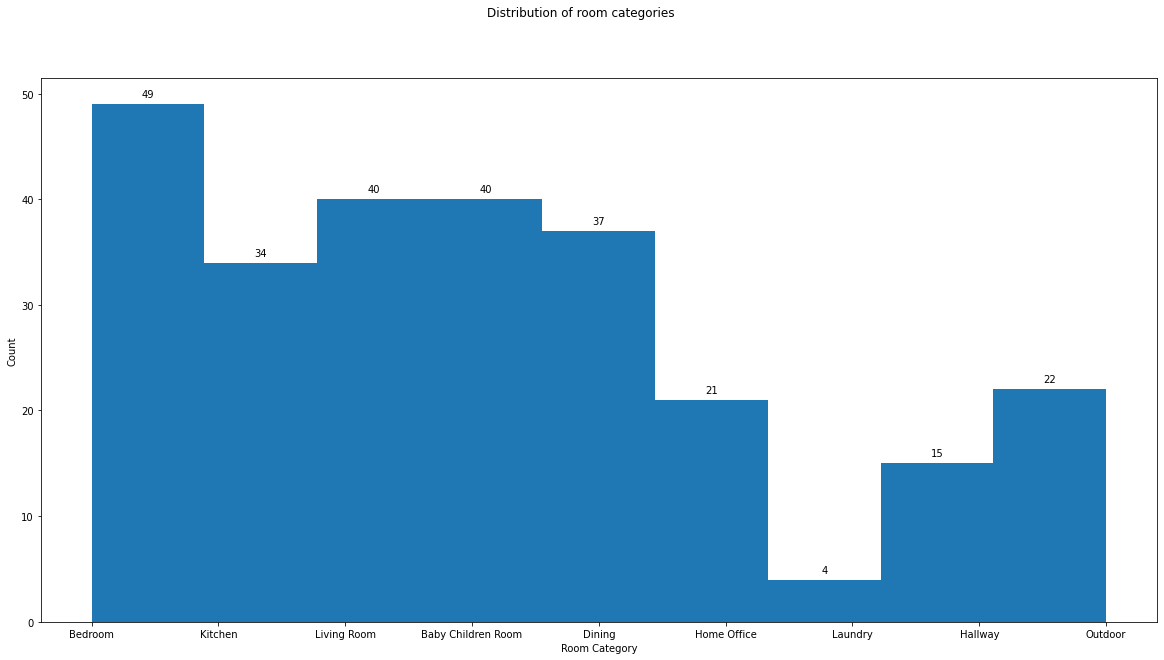

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(list(room_categories.values()), align="mid", bins=len(set(room_categories.values())))

fig.suptitle('Distribution of room categories', fontsize=12)
ax.set_xlabel('Room Category', fontsize=10)
ax.set_ylabel('Count', fontsize='medium')

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

### Bert Encoding Step

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
simple_model = BertModel.from_pretrained('bert-base-uncased')
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')


def simple_bert_embedder(tokenizer, simple_model, sentences):
  inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)
  outputs = simple_model(**inputs)
  return torch.mean(outputs.last_hidden_state, axis=1)

def sentence_bert_embedder(sbert_model, sentences):
  return sbert_model.encode(sentences)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
all_words = get_all_unique_words(unique_descriptions)

In [26]:
simple_embeddings = simple_bert_embedder(tokenizer, simple_model, all_words[:500])

In [27]:
bert_word_emb_np = simple_embeddings.detach().numpy()

In [28]:
bert_word_emb_np.shape

(500, 768)

In [29]:
word_to_bert_emb = {}
for i in range(len(all_words[:500])):
  word_to_bert_emb[all_words[i].lower()] = bert_word_emb_np[i]

In [30]:
# sentbert_embeddings = sentence_bert_embedder(sbert_model, list(item_to_description.values())[:10])

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def tsne_plot(word_to_emb_dict):
    # https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
    # In word_to_emb_dict, we map a word to corresponding numpy embedding vector of shape (n, )
    labels = []
    tokens = []

    for word, emb in word_to_emb_dict.items():
      tokens.append(emb)
      labels.append(word)
    
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

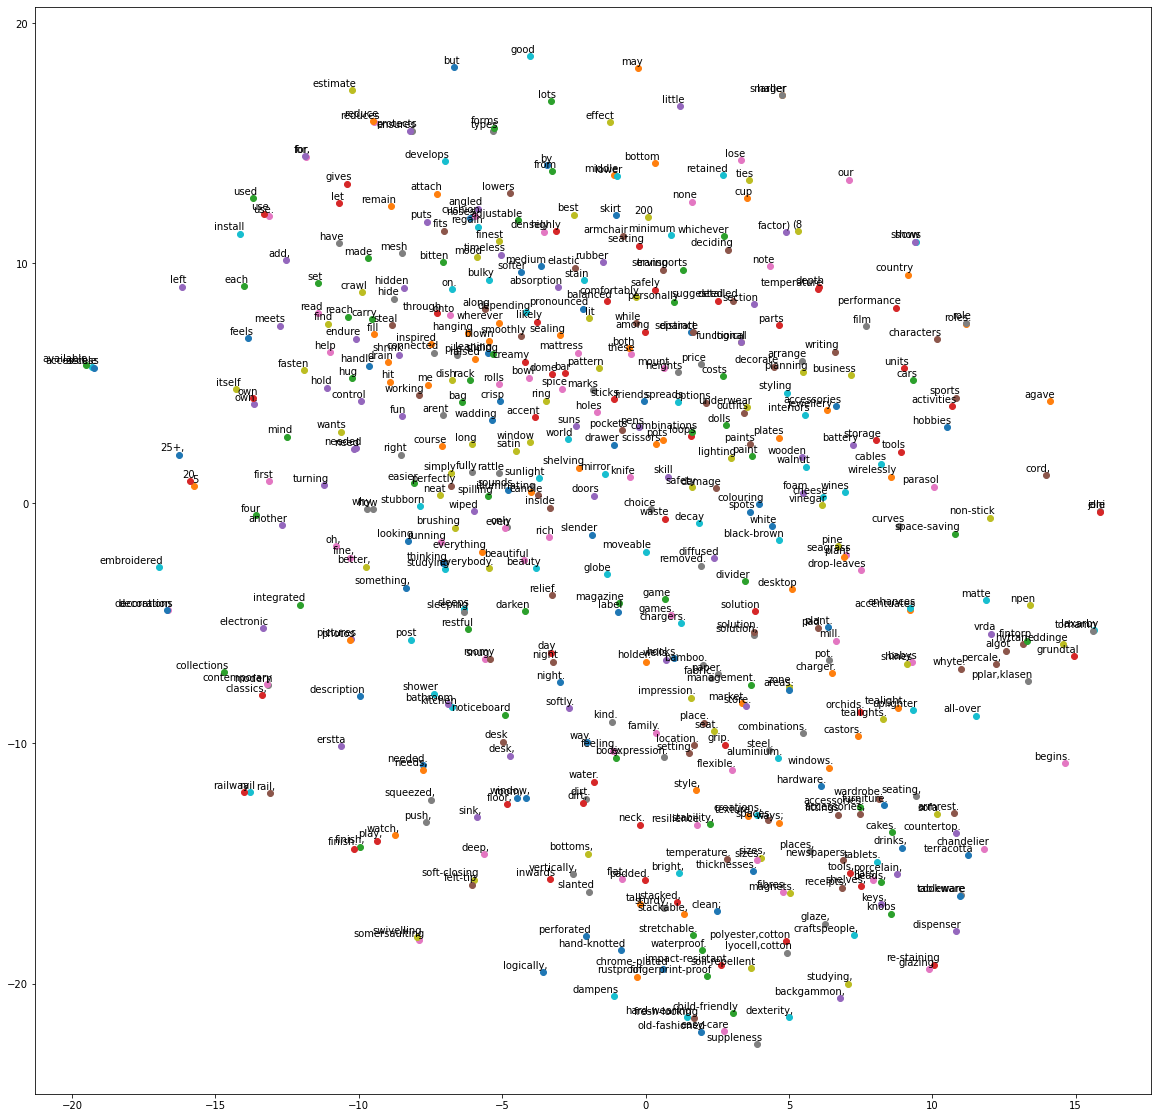

In [34]:
tsne_plot(word_to_bert_emb)

In [25]:
len(word_to_bert_emb.keys())

300